In [26]:
import os
import json
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from tqdm import tqdm
from PIL import Image

warnings.filterwarnings('ignore')

# for visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Starting FairFace Bias-Aware Computer Vision Project")
print(f"PyTorch Version: {torch.__version__}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Starting FairFace Bias-Aware Computer Vision Project
PyTorch Version: 2.6.0+cu124
Device: cuda


In [27]:

# 1. DATASET CONFIGURATION

# Auto-detect the dataset structure in Kaggle
print("\n DATASET CONFIGURATION")
DATASET_BASE = None

# Find the FairFace dataset automatically
if os.path.exists("/kaggle/input"):
    available_datasets = os.listdir("/kaggle/input")
    print(f" Available datasets: {available_datasets}")
    
    # Look for FairFace dataset
    for dataset in available_datasets:
        if 'fairface' in dataset.lower():
            DATASET_BASE = f"/kaggle/input/{dataset}"
            print(f" Found FairFace dataset: {DATASET_BASE}")
            break
    
    # Use first dataset if FairFace not found
    if DATASET_BASE is None and available_datasets:
        DATASET_BASE = f"/kaggle/input/{available_datasets[0]}"
        print(f" Using first available dataset: {DATASET_BASE}")
else:
    DATASET_BASE = "/kaggle/input/fairface"  

# Handle nested structure (fairface/FairFace/)
INNER_PATH = f"{DATASET_BASE}/FairFace" if os.path.exists(f"{DATASET_BASE}/FairFace") else DATASET_BASE
print(f" Using dataset path: {INNER_PATH}")

# Define paths
TRAIN_IMAGES_DIR = f"{INNER_PATH}/train"
VAL_IMAGES_DIR = f"{INNER_PATH}/val"
TRAIN_LABELS_CSV = f"{INNER_PATH}/train_labels.csv"
VAL_LABELS_CSV = f"{INNER_PATH}/val_labels.csv"

TRAIN_LABELS_CSV = os.path.join(INNER_PATH, "train_labels.csv")
VAL_LABELS_CSV   = os.path.join(INNER_PATH, "val_labels.csv")
TRAIN_IMAGES_DIR = os.path.join(INNER_PATH, "train")
VAL_IMAGES_DIR   = os.path.join(INNER_PATH, "val")

# Create output directories
os.makedirs("outputs/splits", exist_ok=True)
os.makedirs("outputs/checkpoints", exist_ok=True)
os.makedirs("outputs/reports", exist_ok=True)
os.makedirs("outputs/visualizations", exist_ok=True)

print(" Directories created successfully")


 DATASET CONFIGURATION
 Available datasets: ['fairface']
 Found FairFace dataset: /kaggle/input/fairface
 Using dataset path: /kaggle/input/fairface/FairFace
 Directories created successfully


In [46]:
# Dataset info

import pandas as pd

# Use your dataset path variables
df_train = pd.read_csv(TRAIN_LABELS_CSV)
df_val   = pd.read_csv(VAL_LABELS_CSV)

print("Train CSV info:")
print(df_train.info())

print("\nValidation CSV info:")
print(df_val.info())


Train CSV info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86744 entries, 0 to 86743
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   file          86744 non-null  object
 1   age           86744 non-null  object
 2   gender        86744 non-null  object
 3   race          86744 non-null  object
 4   service_test  86744 non-null  bool  
dtypes: bool(1), object(4)
memory usage: 2.7+ MB
None

Validation CSV info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10954 entries, 0 to 10953
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   file          10954 non-null  object
 1   age           10954 non-null  object
 2   gender        10954 non-null  object
 3   race          10954 non-null  object
 4   service_test  10954 non-null  bool  
dtypes: bool(1), object(4)
memory usage: 353.1+ KB
None


In [28]:
# 2. UTILITY FUNCTIONS

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def print_dataset_info(csv_path, name="Dataset"):
    print(f"\n Analyzing {name}")
    print(f"   Path: {csv_path}")
    
    if not os.path.exists(csv_path):
        print(f" {name} file not found!")
        directory = os.path.dirname(csv_path)
        if os.path.exists(directory):
            files = [f for f in os.listdir(directory) if f.endswith('.csv')]
            if files:
                print(f"   Available CSV files: {files}")
            else:
                print("   No CSV files found in directory")
        return None
    
    try:
        df = pd.read_csv(csv_path)
        print(f" {name} loaded successfully!")
        print(f"  Shape: {df.shape}")
        print(f"  Columns: {list(df.columns)}")
        
        # Gender analysis 
        if 'gender' in df.columns:
            gender_dist = df['gender'].value_counts()
            print(f"   Gender Distribution:")
            for gender, count in gender_dist.items():
                pct = (count/len(df)) * 100
                print(f"     {gender}: {count:,} ({pct:.1f}%)")
        
        # Race analysis
        if 'race' in df.columns:
            race_dist = df['race'].value_counts()
            print(f"   Race Distribution: {len(race_dist)} groups")
            for race, count in race_dist.head(3).items():
                pct = (count/len(df)) * 100
                print(f"     {race}: {count:,} ({pct:.1f}%)")
        
        print(f"   Sample data:")
        if all(col in df.columns for col in ['file', 'gender', 'race']):
            print(df[['file', 'gender', 'race']].head(3).to_string(index=False))
        
        return df
        
    except Exception as e:
        print(f" Error loading {name}: {str(e)}")
        return None

In [29]:
# 3. DATASET CLASS AND TRANSFORMS

GENDER_MAP = {"male": 0, "female": 1, "Male": 0, "Female": 1, "M": 0, "F": 1}

def build_transforms(img_size=224, augment=True):
    if augment:
        return transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
            transforms.RandomRotation(degrees=10),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    else:
        return transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

class FairFaceDataset(Dataset):
    
    def __init__(self, csv_path, image_dir, img_size=224, augment=False, file_col="file", label_col="gender"):
        self.df = pd.read_csv(csv_path)
        self.image_dir = image_dir
        self.transforms = build_transforms(img_size, augment)
        

        possible_file_cols = [file_col, "filename", "image", "img_path", "file_name"]
        self.file_col = None
        for col in possible_file_cols:
            if col in self.df.columns:
                self.file_col = col
                break
        
        if self.file_col is None:
            raise ValueError(f"No file column found. Available columns: {list(self.df.columns)}")
        
        self.label_col = label_col
        if label_col not in self.df.columns:
            raise ValueError(f"Label column '{label_col}' not found. Available: {list(self.df.columns)}")
            
        print(f" Dataset initialized: {len(self.df)} samples")
        print(f" File column: {self.file_col}")
        print(f" Label column: {self.label_col}")
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Handle image path 
        img_filename = str(row[self.file_col])
        

        if img_filename.startswith(('train/', 'val/')):
            img_filename = img_filename.split('/')[-1]  # Get just "1.jpg"
        
        img_path = os.path.join(self.image_dir, img_filename)
        
        # Load and convert image with better error handling
        try:
            if os.path.exists(img_path):
                image = Image.open(img_path).convert("RGB")
            else:
              
                gender = str(row[self.label_col])
                if gender == 'Male':
                    color = (100, 150, 255)  # Blue for male
                else:
                    color = (255, 150, 150)  # Pink for female
                    
                image = Image.new("RGB", (224, 224), color=color)
                if idx < 3: 
                    print(f" Image not found: {img_path}, using dummy image")
                    
        except Exception as e:
          
            image = Image.new("RGB", (224, 224), color=(128, 128, 128))
            if idx < 3:
                print(f" Error loading {img_filename}: {e}")
        
        x = self.transforms(image)
        
        gender_raw = str(row[self.label_col]).strip()
        if gender_raw == 'Male':
            y = 0  # Male
        elif gender_raw == 'Female':
            y = 1  # Female
        else:
            gender_lower = gender_raw.lower()
            if gender_lower.startswith('m'):
                y = 0
            elif gender_lower.startswith('f'):
                y = 1
            else:
                raise ValueError(f"Unknown gender value: {gender_raw}")
        
        return x, y, str(row[self.file_col])


In [30]:
# 4. BIAS-AWARE DATA SPLITTING

def create_biased_splits(df, output_dir="outputs/splits", seed=42):
    
    def normalize_gender(df, gender_col="gender"):
        df = df.copy()
        df[gender_col] = df[gender_col].astype(str).str.lower()
        df[gender_col] = df[gender_col].apply(lambda x: 'male' if x.startswith('m') else 'female')
        return df
    
    def create_ratio_split(df, male_ratio, female_ratio, name, output_dir):
        df_norm = normalize_gender(df)
        males = df_norm[df_norm['gender'] == 'male']
        females = df_norm[df_norm['gender'] == 'female']
        
        total_samples = min(len(df_norm), 10000)  # Limit for faster processing
        target_male = int(total_samples * male_ratio)
        target_female = int(total_samples * female_ratio)
        
        if len(males) < target_male:
            male_sample = males.sample(target_male, replace=True, random_state=seed)
        else:
            male_sample = males.sample(target_male, random_state=seed)
            
        if len(females) < target_female:
            female_sample = females.sample(target_female, replace=True, random_state=seed)
        else:
            female_sample = females.sample(target_female, random_state=seed)
        
        combined = pd.concat([male_sample, female_sample], ignore_index=True)
        combined = combined.sample(frac=1, random_state=seed).reset_index(drop=True)
        
        output_path = os.path.join(output_dir, f"{name}.csv")
        combined.to_csv(output_path, index=False)
        
        print(f" Created {name}: {len(combined)} samples")
        print(f"   Gender distribution: {dict(combined['gender'].value_counts())}")
        
        return output_path
    
    # Create different bias scenarios
    splits = {}
    
    # Biased splits for training
    splits['train_biased_male'] = create_ratio_split(df, 0.8, 0.2, "train_biased_male", output_dir)
    splits['train_biased_female'] = create_ratio_split(df, 0.2, 0.8, "train_biased_female", output_dir)
    splits['train_balanced'] = create_ratio_split(df, 0.5, 0.5, "train_balanced", output_dir)
    
    return splits


In [31]:
# 5. MODEL ARCHITECTURES


def create_model(architecture="resnet18", num_classes=2, pretrained=True):
    
    if architecture == "resnet18":
        model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
    
    elif architecture == "efficientnet_b0":
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT if pretrained else None)
        in_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_features, num_classes)
    
    elif architecture == "mobilenet_v2":
        model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT if pretrained else None)
        in_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_features, num_classes)
    
    else:
        raise ValueError(f"Unsupported architecture: {architecture}")
    
    return model

In [32]:
# 6. FAIRNESS-AWARE TRAINING

def compute_class_weights(train_csv, label_col="gender"):
    df = pd.read_csv(train_csv)
    gender_labels = df[label_col].astype(str).str.lower()
    labels = [0 if g.startswith('m') else 1 for g in gender_labels]
    
    counts = np.bincount(labels, minlength=2)
    weights = 1.0 / np.maximum(counts, 1)
    return torch.tensor(weights, dtype=torch.float32)

def mixup_data(x, y, alpha=0.2):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    
    batch_size = x.size()[0]
    index = torch.randperm(batch_size, device=x.device)
    
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    
    return mixed_x, y_a, y_b, lam

def train_epoch(model, train_loader, optimizer, criterion, device, use_mixup=False):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc="Training", leave=False)
    
    for batch_idx, (data, target, _) in enumerate(progress_bar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        if use_mixup and np.random.rand() < 0.5:
            mixed_data, target_a, target_b, lam = mixup_data(data, target)
            output = model(mixed_data)
            loss = lam * criterion(output, target_a) + (1 - lam) * criterion(output, target_b)
        else:
            output = model(data)
            loss = criterion(output, target)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)
        
        progress_bar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{100. * correct / total:.2f}%'
        })
    
    return total_loss / len(train_loader), 100. * correct / total

@torch.no_grad()
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    all_probs = []
    
    progress_bar = tqdm(test_loader, desc="Evaluating", leave=False)
    
    for data, target, _ in progress_bar:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        
        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        total += target.size(0)
        
        # Store predictions and probabilities
        all_preds.extend(pred.cpu().numpy())
        all_targets.extend(target.cpu().numpy())
        probs = F.softmax(output, dim=1)
        all_probs.extend(probs.cpu().numpy())
    
    accuracy = 100. * correct / total
    avg_loss = total_loss / len(test_loader)
    
    return avg_loss, accuracy, np.array(all_targets), np.array(all_preds), np.array(all_probs)

def train_fair_model(train_csv, val_csv, train_img_dir, val_img_dir, 
                    architecture="resnet18", epochs=10, batch_size=32, 
                    learning_rate=1e-3, experiment_name="fair_model"):
    
    print(f"\n Training Fair Model: {experiment_name}")
    print(f"Architecture: {architecture}")
    print(f"Epochs: {epochs}, Batch Size: {batch_size}, LR: {learning_rate}")
    
    train_dataset = FairFaceDataset(train_csv, train_img_dir, augment=True)
    val_dataset = FairFaceDataset(val_csv, val_img_dir, augment=False)
    
    # Create balanced sampling for training
    train_df = pd.read_csv(train_csv)
    gender_labels = train_df['gender'].astype(str).str.lower()
    labels = [0 if g.startswith('m') else 1 for g in gender_labels]
    
    # Compute sample weights for balanced sampling
    class_counts = np.bincount(labels, minlength=2)
    class_weights = 1.0 / class_counts
    sample_weights = [class_weights[label] for label in labels]
    
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        sampler=sampler,
        num_workers=2, 
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=2, 
        pin_memory=True
    )
    
    # Initialize model
    model = create_model(architecture, num_classes=2, pretrained=True).to(device)
    
    # Loss and optimizer with class weights
    class_weights_tensor = compute_class_weights(train_csv).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    # Training loop
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    best_val_acc = 0
    best_model_path = f"outputs/checkpoints/{experiment_name}_best.pt"
    
    print("\n Starting Training...")
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device, use_mixup=True)
        
        # Validate
        val_loss, val_acc, _, _, _ = evaluate_model(model, val_loader, criterion, device)
        
        scheduler.step()
        
        # Store metrics
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'model_state_dict': model.state_dict(),
                'architecture': architecture,
                'val_acc': val_acc,
                'epoch': epoch
            }, best_model_path)
            print(f"New best model saved! Val Acc: {val_acc:.2f}%")
    
    print(f"\n Training completed! Best Val Acc: {best_val_acc:.2f}%")
    
    return best_model_path, {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs
    }

In [33]:
# 7. FAIRNESS METRICS

def compute_fairness_metrics(y_true, y_pred, y_prob, protected_attribute):
    
    metrics = {}
    
    # Basic accuracy metrics
    overall_acc = np.mean(y_true == y_pred)
    metrics['overall_accuracy'] = overall_acc
    
    # Group-wise accuracy
    unique_groups = np.unique(protected_attribute)
    group_accs = {}
    
    for group in unique_groups:
        mask = protected_attribute == group
        if np.sum(mask) > 0:
            group_acc = np.mean(y_true[mask] == y_pred[mask])
            group_accs[f'group_{group}_accuracy'] = group_acc
    
    metrics.update(group_accs)
    
    # Demographic Parity (Equal Positive Rate)
    positive_rates = {}
    for group in unique_groups:
        mask = protected_attribute == group
        if np.sum(mask) > 0:
            pos_rate = np.mean(y_pred[mask] == 1)  # Assuming 1 is positive class
            positive_rates[f'group_{group}_positive_rate'] = pos_rate
    
    metrics.update(positive_rates)
    
    # Demographic Parity Difference
    if len(unique_groups) == 2:
        dp_diff = abs(positive_rates[f'group_{unique_groups[0]}_positive_rate'] - 
                     positive_rates[f'group_{unique_groups[1]}_positive_rate'])
        metrics['demographic_parity_difference'] = dp_diff
    
    # Equalized Odds (True Positive Rate and False Positive Rate equality)
    tpr_dict = {}
    fpr_dict = {}
    
    for group in unique_groups:
        mask = protected_attribute == group
        if np.sum(mask) > 0:
            y_true_group = y_true[mask]
            y_pred_group = y_pred[mask]
            
            # True Positive Rate
            tp = np.sum((y_true_group == 1) & (y_pred_group == 1))
            fn = np.sum((y_true_group == 1) & (y_pred_group == 0))
            tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
            tpr_dict[f'group_{group}_tpr'] = tpr
            
            # False Positive Rate
            fp = np.sum((y_true_group == 0) & (y_pred_group == 1))
            tn = np.sum((y_true_group == 0) & (y_pred_group == 0))
            fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
            fpr_dict[f'group_{group}_fpr'] = fpr
    
    metrics.update(tpr_dict)
    metrics.update(fpr_dict)
    
    # Equalized Odds Difference
    if len(unique_groups) == 2:
        tpr_diff = abs(tpr_dict[f'group_{unique_groups[0]}_tpr'] - 
                      tpr_dict[f'group_{unique_groups[1]}_tpr'])
        fpr_diff = abs(fpr_dict[f'group_{unique_groups[0]}_fpr'] - 
                      fpr_dict[f'group_{unique_groups[1]}_fpr'])
        
        metrics['tpr_difference'] = tpr_diff
        metrics['fpr_difference'] = fpr_diff
        metrics['equalized_odds_difference'] = (tpr_diff + fpr_diff) / 2
    
    return metrics

In [34]:
# 8. VISUALIZATION FUNCTIONS

def plot_training_history(history, experiment_name):
    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 5))
    
    epochs = range(1, len(history['train_losses']) + 1)
    
    # Loss plot
    ax1.plot(epochs, history['train_losses'], 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, history['val_losses'], 'r-', label='Validation Loss', linewidth=2)
    ax1.set_title(f'Training History - {experiment_name}', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Accuracy plot
    ax2.plot(epochs, history['train_accs'], 'b-', label='Training Accuracy', linewidth=2)
    ax2.plot(epochs, history['val_accs'], 'r-', label='Validation Accuracy', linewidth=2)
    ax2.set_title(f'Accuracy History - {experiment_name}', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'outputs/visualizations/{experiment_name}_training_history.png', 
                dpi=300, bbox_inches='tight')
    plt.show()

def plot_confusion_matrix(y_true, y_pred, experiment_name, class_names=['Male', 'Female']):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    
    plt.title(f'Confusion Matrix - {experiment_name}', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(f'outputs/visualizations/{experiment_name}_confusion_matrix.png', 
                dpi=300, bbox_inches='tight')
    plt.show()

def plot_fairness_metrics_comparison(results_dict):
    
    experiments = list(results_dict.keys())
    metrics_to_plot = [
        'overall_accuracy', 
        'group_0_accuracy', 
        'group_1_accuracy',
        'demographic_parity_difference',
        'equalized_odds_difference'
    ]
    
    # Prepare data
    plot_data = []
    for exp in experiments:
        for metric in metrics_to_plot:
            if metric in results_dict[exp]['fairness_metrics']:
                plot_data.append({
                    'Experiment': exp,
                    'Metric': metric.replace('_', ' ').title(),
                    'Value': results_dict[exp]['fairness_metrics'][metric]
                })
    
    df_plot = pd.DataFrame(plot_data)
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, metric in enumerate(metrics_to_plot):
        metric_title = metric.replace('_', ' ').title()
        metric_data = df_plot[df_plot['Metric'] == metric_title]
        
        if not metric_data.empty:
            sns.barplot(data=metric_data, x='Experiment', y='Value', ax=axes[i])
            axes[i].set_title(f'{metric_title}', fontsize=12, fontweight='bold')
            axes[i].set_xlabel('')
            axes[i].tick_params(axis='x', rotation=45)
            axes[i].grid(True, alpha=0.3)
    
    if len(metrics_to_plot) < len(axes):
        fig.delaxes(axes[-1])
    
    plt.suptitle('Fairness Metrics Comparison Across Experiments', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('outputs/visualizations/fairness_comparison.png', 
                dpi=300, bbox_inches='tight')
    plt.show()

def plot_demographic_analysis(y_true, y_pred, protected_attr, experiment_name):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Group-wise accuracy
    unique_groups = np.unique(protected_attr)
    group_names = ['Male', 'Female']
    accuracies = []
    
    for group in unique_groups:
        mask = protected_attr == group
        if np.sum(mask) > 0:
            acc = np.mean(y_true[mask] == y_pred[mask])
            accuracies.append(acc)
        else:
            accuracies.append(0)
    
    # Accuracy by group
    bars1 = axes[0, 0].bar(group_names, accuracies, color=['skyblue', 'lightcoral'])
    axes[0, 0].set_title('Accuracy by Gender Group', fontweight='bold')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_ylim(0, 1)
    axes[0, 0].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, acc) in enumerate(zip(bars1, accuracies)):
        axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                       f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Positive prediction rates by group
    pos_rates = []
    for group in unique_groups:
        mask = protected_attr == group
        if np.sum(mask) > 0:
            pos_rate = np.mean(y_pred[mask] == 1)
            pos_rates.append(pos_rate)
        else:
            pos_rates.append(0)
    
    bars2 = axes[0, 1].bar(group_names, pos_rates, color=['lightgreen', 'salmon'])
    axes[0, 1].set_title('Positive Prediction Rate by Gender Group', fontweight='bold')
    axes[0, 1].set_ylabel('Positive Prediction Rate')
    axes[0, 1].set_ylim(0, 1)
    axes[0, 1].grid(True, alpha=0.3)
    
    for i, (bar, rate) in enumerate(zip(bars2, pos_rates)):
        axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                       f'{rate:.3f}', ha='center', va='bottom', fontweight='bold')
    
 
    pred_dist = pd.DataFrame({
        'Gender': ['Male' if g == 0 else 'Female' for g in protected_attr],
        'Prediction': ['Male' if p == 0 else 'Female' for p in y_pred]
    })
    
    pred_crosstab = pd.crosstab(pred_dist['Gender'], pred_dist['Prediction'], normalize='index')
    pred_crosstab.plot(kind='bar', stacked=True, ax=axes[1, 0], color=['skyblue', 'lightcoral'])
    axes[1, 0].set_title('Prediction Distribution by Gender Group', fontweight='bold')
    axes[1, 0].set_ylabel('Proportion')
    axes[1, 0].legend(title='Predicted Gender')
    axes[1, 0].tick_params(axis='x', rotation=0)
    axes[1, 0].grid(True, alpha=0.3)
    
    # True vs Predicted distribution
    true_dist = pd.DataFrame({
        'Gender': ['Male' if g == 0 else 'Female' for g in protected_attr],
        'True_Label': ['Male' if t == 0 else 'Female' for t in y_true],
        'Predicted_Label': ['Male' if p == 0 else 'Female' for p in y_pred]
    })
    
    # Calculate per-group confusion matrices
    male_mask = protected_attr == 0
    female_mask = protected_attr == 1
    
    if np.sum(male_mask) > 0 and np.sum(female_mask) > 0:
        male_cm = confusion_matrix(y_true[male_mask], y_pred[male_mask], labels=[0, 1])
        female_cm = confusion_matrix(y_true[female_mask], y_pred[female_mask], labels=[0, 1])
        
        # Normalize confusion matrices
        male_cm_norm = male_cm.astype('float') / male_cm.sum(axis=1)[:, np.newaxis]
        female_cm_norm = female_cm.astype('float') / female_cm.sum(axis=1)[:, np.newaxis]
        
        # Plot normalized confusion matrices side by side
        im1 = axes[1, 1].imshow(male_cm_norm, interpolation='nearest', cmap='Blues', vmin=0, vmax=1)
        axes[1, 1].set_title('Male Group - Normalized Confusion Matrix', fontweight='bold')
        axes[1, 1].set_xticks([0, 1])
        axes[1, 1].set_yticks([0, 1])
        axes[1, 1].set_xticklabels(['Pred Male', 'Pred Female'])
        axes[1, 1].set_yticklabels(['True Male', 'True Female'])
        
        for i in range(2):
            for j in range(2):
                text = axes[1, 1].text(j, i, f'{male_cm_norm[i, j]:.3f}',
                                     ha="center", va="center", color="black", fontweight='bold')
    
    plt.suptitle(f'Demographic Analysis - {experiment_name}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'outputs/visualizations/{experiment_name}_demographic_analysis.png', 
                dpi=300, bbox_inches='tight')
    plt.show()

def create_fairness_dashboard(results_dict):
    
    fig = plt.figure(figsize=(20, 15))
    
    gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)
    
    experiments = list(results_dict.keys())
    colors = plt.cm.Set3(np.linspace(0, 1, len(experiments)))
    
    # 1. Overall Accuracy Comparison
    ax1 = fig.add_subplot(gs[0, 0])
    accuracies = [results_dict[exp]['fairness_metrics']['overall_accuracy'] for exp in experiments]
    bars = ax1.bar(range(len(experiments)), accuracies, color=colors)
    ax1.set_title('Overall Accuracy', fontweight='bold')
    ax1.set_xticks(range(len(experiments)))
    ax1.set_xticklabels([exp.replace('_', '\n') for exp in experiments], rotation=0, fontsize=10)
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim(0, 1)
    ax1.grid(True, alpha=0.3)
    
    for bar, acc in zip(bars, accuracies):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{acc:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    # 2. Gender Group Accuracy Comparison
    ax2 = fig.add_subplot(gs[0, 1])
    male_accs = [results_dict[exp]['fairness_metrics']['group_0_accuracy'] for exp in experiments]
    female_accs = [results_dict[exp]['fairness_metrics']['group_1_accuracy'] for exp in experiments]
    
    x = np.arange(len(experiments))
    width = 0.35
    
    ax2.bar(x - width/2, male_accs, width, label='Male', color='skyblue')
    ax2.bar(x + width/2, female_accs, width, label='Female', color='lightcoral')
    ax2.set_title('Accuracy by Gender Group', fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels([exp.replace('_', '\n') for exp in experiments], fontsize=10)
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Fairness Metrics Heatmap
    ax3 = fig.add_subplot(gs[0, 2:])
    fairness_metrics = ['demographic_parity_difference', 'equalized_odds_difference', 'tpr_difference', 'fpr_difference']
    
    heatmap_data = []
    for exp in experiments:
        row = []
        for metric in fairness_metrics:
            if metric in results_dict[exp]['fairness_metrics']:
                row.append(results_dict[exp]['fairness_metrics'][metric])
            else:
                row.append(0)
        heatmap_data.append(row)
    
    heatmap_data = np.array(heatmap_data)
    im = ax3.imshow(heatmap_data, cmap='RdYlBu_r', aspect='auto')
    ax3.set_title('Fairness Metrics Heatmap (Lower is Better)', fontweight='bold')
    ax3.set_xticks(range(len(fairness_metrics)))
    ax3.set_xticklabels([m.replace('_', ' ').title() for m in fairness_metrics], rotation=45, ha='right')
    ax3.set_yticks(range(len(experiments)))
    ax3.set_yticklabels([exp.replace('_', ' ') for exp in experiments])
    
    cbar = plt.colorbar(im, ax=ax3, fraction=0.046, pad=0.04)
    cbar.set_label('Difference Score', rotation=270, labelpad=15)

    for i in range(len(experiments)):
        for j in range(len(fairness_metrics)):
            ax3.text(j, i, f'{heatmap_data[i, j]:.3f}', ha='center', va='center', 
                    color='white' if heatmap_data[i, j] > 0.5 else 'black', fontweight='bold')
    
    # 4. Training Performance Comparison
    ax4 = fig.add_subplot(gs[1, :2])
    for i, exp in enumerate(experiments):
        if 'training_history' in results_dict[exp]:
            epochs = range(1, len(results_dict[exp]['training_history']['val_accs']) + 1)
            ax4.plot(epochs, results_dict[exp]['training_history']['val_accs'], 
                    label=exp.replace('_', ' '), linewidth=2, color=colors[i])
    
    ax4.set_title('Validation Accuracy During Training', fontweight='bold')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Validation Accuracy (%)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Bias Analysis Summary
    ax5 = fig.add_subplot(gs[1, 2:])
    
    summary_data = []
    for exp in experiments:
        metrics = results_dict[exp]['fairness_metrics']
        summary_data.append([
            f"{metrics['overall_accuracy']:.3f}",
            f"{abs(metrics['group_0_accuracy'] - metrics['group_1_accuracy']):.3f}",
            f"{metrics['demographic_parity_difference']:.3f}",
            f"{metrics['equalized_odds_difference']:.3f}"
        ])
    
    table = ax5.table(cellText=summary_data,
                     rowLabels=[exp.replace('_', ' ') for exp in experiments],
                     colLabels=['Overall Acc', 'Acc Diff', 'Dem Parity', 'Eq Odds'],
                     cellLoc='center',
                     loc='center')
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    ax5.axis('off')
    ax5.set_title('Key Metrics Summary', fontweight='bold', pad=20)
    
    # 6. Recommendations
    ax6 = fig.add_subplot(gs[2, :])
    ax6.axis('off')
    
    recommendations = []
    
    best_overall_exp = experiments[np.argmax([results_dict[exp]['fairness_metrics']['overall_accuracy'] for exp in experiments])]
    recommendations.append(f"• Best Overall Performance: {best_overall_exp.replace('_', ' ')}")
    
    fairest_exp = experiments[np.argmin([results_dict[exp]['fairness_metrics']['demographic_parity_difference'] for exp in experiments])]
    recommendations.append(f"• Most Fair (Demographic Parity): {fairest_exp.replace('_', ' ')}")
    
    if any('balanced' in exp for exp in experiments):
        recommendations.append("• Balanced training data generally provides better fairness-performance trade-off")
    
    recommendations.append("• Consider ensemble methods for improved robustness")
    recommendations.append("• Regular monitoring and retraining recommended for deployed systems")
    
    recommendation_text = "Key Findings and Recommendations:\n\n" + "\n".join(recommendations)
    
    ax6.text(0.05, 0.95, recommendation_text, transform=ax6.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7),
            fontweight='normal')
    
    plt.suptitle('FairFace Bias Analysis Dashboard', fontsize=20, fontweight='bold', y=0.98)
    plt.savefig('outputs/visualizations/fairness_dashboard.png', dpi=300, bbox_inches='tight')
    plt.show()


In [35]:
# 9. POST-HOC EXPLAINABILITY

class GradCAM:
    
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)
    
    def save_activation(self, module, input, output):
        self.activations = output
    
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]
    
    def generate_cam(self, input_image, class_idx):
        self.model.zero_grad(set_to_none=True)
        with torch.enable_grad():
            output = self.model(input_image)
            score = output[0, class_idx]

        score.backward(retain_graph=True)
        
        # Generate CAM
        gradients = self.gradients.detach().cpu().numpy()[0]
        activations = self.activations.detach().cpu().numpy()[0]
        
        weights = np.mean(gradients, axis=(1, 2))
        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        
        for i, w in enumerate(weights):
            cam += w * activations[i]
        
        cam = np.maximum(cam, 0)
        cam = cam / cam.max() if cam.max() > 0 else cam
        
        return cam


def visualize_model_explanations(model, dataset, device, num_samples=8, experiment_name="model"):
    
    print(f"\n Generating Model Explanations for {experiment_name}")
    
    # Get target layer (last conv layer)
    if hasattr(model, 'features'):  # For models like VGG
        target_layer = model.features[-1]
    elif hasattr(model, 'layer4'):  # For ResNet
        target_layer = model.layer4[-1].conv2
    elif hasattr(model, 'classifier'):  # For EfficientNet
        target_layer = model.features[-1]
    else:
        print("Could not find appropriate layer for GradCAM")
        return
    
    # Initialize GradCAM
    grad_cam = GradCAM(model, target_layer)
    
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
    
    fig, axes = plt.subplots(2, num_samples // 2, figsize=(20, 8))
    axes = axes.flatten()
    
    model.eval()
    sample_count = 0
    
    for batch_idx, (data, target, filename) in enumerate(dataloader):
        if sample_count >= num_samples:
            break
        
        data = data.to(device)
        data.requires_grad_()  
        
        with torch.enable_grad():
 
            output = model(data)
            pred_class = torch.argmax(output, dim=1).item()
            confidence = torch.softmax(output, dim=1).max().item()
        
        # Generate CAM
        cam = grad_cam.generate_cam(data, pred_class)
        
        # Convert to display format
        img_data = data.detach().cpu().squeeze().numpy()
        img_data = np.transpose(img_data, (1, 2, 0))
        
        # Denormalize
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_data = img_data * std + mean
        img_data = np.clip(img_data, 0, 1)
        
        # Resize CAM to match image
        cam_resized = np.array(Image.fromarray(cam).resize((224, 224), Image.BILINEAR))
        
        # Overlay CAM on image
        axes[sample_count].imshow(img_data)
        axes[sample_count].imshow(cam_resized, alpha=0.4, cmap='jet')
        
        true_label = 'Male' if target.item() == 0 else 'Female'
        pred_label = 'Male' if pred_class == 0 else 'Female'
        
        axes[sample_count].set_title(
            f'True: {true_label}, Pred: {pred_label}\nConf: {confidence:.3f}',
            fontsize=10, fontweight='bold'
        )
        axes[sample_count].axis('off')
        
        sample_count += 1
    
    plt.suptitle(f'Model Explanations (GradCAM) - {experiment_name}', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'outputs/visualizations/{experiment_name}_explanations.png', 
                dpi=300, bbox_inches='tight')
    plt.show()

In [36]:
# Dataset Loading and Preparation

print(" STEP 1: DATASET PREPARATION")
print("-" * 50)

# Load and analyze datasets
train_df = print_dataset_info(TRAIN_LABELS_CSV, "Training Dataset")
val_df = print_dataset_info(VAL_LABELS_CSV, "Validation Dataset")

if train_df is None or val_df is None:
    print(" Could not load dataset files. Please check your setup:")
    print(f"  Training CSV: {TRAIN_LABELS_CSV}")
    print(f"  Validation CSV: {VAL_LABELS_CSV}")
    print(f"  Training Images: {TRAIN_IMAGES_DIR}")
    print(f"  Validation Images: {VAL_IMAGES_DIR}")
    
    print("\n Searching for CSV files in the dataset directory...")
    if os.path.exists(INNER_PATH):
        csv_files = [f for f in os.listdir(INNER_PATH) if f.endswith('.csv')]
        if csv_files:
            print(f"   Found CSV files: {csv_files}")
            first_csv = os.path.join(INNER_PATH, csv_files[0])
            train_df = print_dataset_info(first_csv, f"Found CSV: {csv_files[0]}")
            if len(csv_files) > 1:
                second_csv = os.path.join(INNER_PATH, csv_files[1])
                val_df = print_dataset_info(second_csv, f"Found CSV: {csv_files[1]}")
                VAL_LABELS_CSV = second_csv
            else:
                # Use the same file for validation (will split later)
                val_df = train_df
                VAL_LABELS_CSV = first_csv
            TRAIN_LABELS_CSV = first_csv
        else:
            print(" No CSV files found!")
    
    if train_df is None:
        print("\n Cannot proceed without dataset. Please verify your Kaggle dataset setup.")

# Create biased splits
if train_df is not None:
    splits = create_biased_splits(train_df)
    print(" Dataset preparation completed!")
else:
    print(" Dataset preparation failed!")


 STEP 1: DATASET PREPARATION
--------------------------------------------------

 Analyzing Training Dataset
   Path: /kaggle/input/fairface/FairFace/train_labels.csv
 Training Dataset loaded successfully!
  Shape: (86744, 5)
  Columns: ['file', 'age', 'gender', 'race', 'service_test']
   Gender Distribution:
     Male: 45,986 (53.0%)
     Female: 40,758 (47.0%)
   Race Distribution: 7 groups
     White: 16,527 (19.1%)
     Latino_Hispanic: 13,367 (15.4%)
     Indian: 12,319 (14.2%)
   Sample data:
       file gender       race
train/1.jpg   Male East Asian
train/2.jpg Female     Indian
train/3.jpg Female      Black

 Analyzing Validation Dataset
   Path: /kaggle/input/fairface/FairFace/val_labels.csv
 Validation Dataset loaded successfully!
  Shape: (10954, 5)
  Columns: ['file', 'age', 'gender', 'race', 'service_test']
   Gender Distribution:
     Male: 5,792 (52.9%)
     Female: 5,162 (47.1%)
   Race Distribution: 7 groups
     White: 2,085 (19.0%)
     Latino_Hispanic: 1,623 (14.8%

In [37]:
# Model Training Configuration Setup  

print("\n STEP 2: FAIRNESS-AWARE MODEL TRAINING SETUP")
print("-" * 50)

results = {}

training_configs = [
    {
        'name': 'biased_male',
        'train_csv': splits['train_biased_male'],
        'description': 'Male-biased training (80% Male, 20% Female)'
    },
    {
        'name': 'biased_female', 
        'train_csv': splits['train_biased_female'],
        'description': 'Female-biased training (20% Male, 80% Female)'
    },
    {
        'name': 'balanced',
        'train_csv': splits['train_balanced'],
        'description': 'Balanced training (50% Male, 50% Female)'
    }
]

print("Training configurations set up:")
for config in training_configs:
    print(f"  • {config['name']}: {config['description']}")



 STEP 2: FAIRNESS-AWARE MODEL TRAINING SETUP
--------------------------------------------------
Training configurations set up:
  • biased_male: Male-biased training (80% Male, 20% Female)
  • biased_female: Female-biased training (20% Male, 80% Female)
  • balanced: Balanced training (50% Male, 50% Female)



 Training: Male-biased training (80% Male, 20% Female)

 Training Fair Model: biased_male
Architecture: resnet18
Epochs: 5, Batch Size: 16, LR: 0.001
 Dataset initialized: 10000 samples
 File column: file
 Label column: gender
 Dataset initialized: 10954 samples
 File column: file
 Label column: gender

 Starting Training...

Epoch 1/5


Train Loss: 0.4814, Train Acc: 54.57%
Val Loss: 0.4168, Val Acc: 60.84%
New best model saved! Val Acc: 60.84%

Epoch 2/5


Train Loss: 0.3945, Train Acc: 62.85%
Val Loss: 0.3875, Val Acc: 60.51%

Epoch 3/5


Train Loss: 0.3318, Train Acc: 68.83%
Val Loss: 0.3146, Val Acc: 78.77%
New best model saved! Val Acc: 78.77%

Epoch 4/5


Train Loss: 0.2971, Train Acc: 73.45%
Val Loss: 0.2789, Val Acc: 77.94%

Epoch 5/5


Train Loss: 0.2376, Train Acc: 78.45%
Val Loss: 0.2743, Val Acc: 84.33%
New best model saved! Val Acc: 84.33%

 Training completed! Best Val Acc: 84.33%


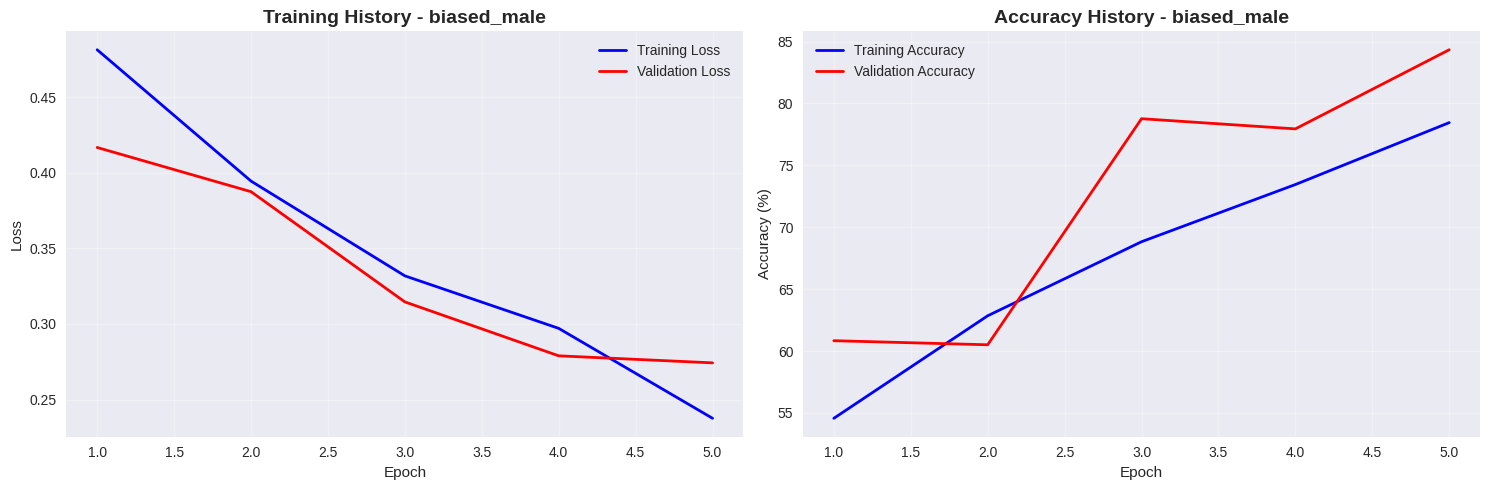

biased_male training completed!


In [38]:
# Train Male-Biased Model

config = training_configs[0]  # biased_male
print(f"\n Training: {config['description']}")

# Train model
model_path, history = train_fair_model(
    train_csv=config['train_csv'],
    val_csv=VAL_LABELS_CSV,
    train_img_dir=TRAIN_IMAGES_DIR,
    val_img_dir=VAL_IMAGES_DIR,
    architecture="resnet18",
    epochs=5,  
    batch_size=16, 
    learning_rate=1e-3,
    experiment_name=config['name']
)

# Plot training history
plot_training_history(history, config['name'])

# Store results
results[config['name']] = {
    'model_path': model_path,
    'training_history': history,
    'description': config['description']
}

print(f"{config['name']} training completed!")



 Training: Female-biased training (20% Male, 80% Female)

 Training Fair Model: biased_female
Architecture: resnet18
Epochs: 5, Batch Size: 16, LR: 0.001
 Dataset initialized: 10000 samples
 File column: file
 Label column: gender
 Dataset initialized: 10954 samples
 File column: file
 Label column: gender

 Starting Training...

Epoch 1/5


Train Loss: 0.4820, Train Acc: 56.42%
Val Loss: 0.3621, Val Acc: 72.58%
New best model saved! Val Acc: 72.58%

Epoch 2/5


Train Loss: 0.3636, Train Acc: 65.92%
Val Loss: 0.3249, Val Acc: 72.20%

Epoch 3/5


Train Loss: 0.3250, Train Acc: 70.17%
Val Loss: 0.2701, Val Acc: 76.62%
New best model saved! Val Acc: 76.62%

Epoch 4/5


Train Loss: 0.2875, Train Acc: 72.76%
Val Loss: 0.2583, Val Acc: 84.28%
New best model saved! Val Acc: 84.28%

Epoch 5/5


Train Loss: 0.2556, Train Acc: 75.95%
Val Loss: 0.2406, Val Acc: 85.28%
New best model saved! Val Acc: 85.28%

 Training completed! Best Val Acc: 85.28%


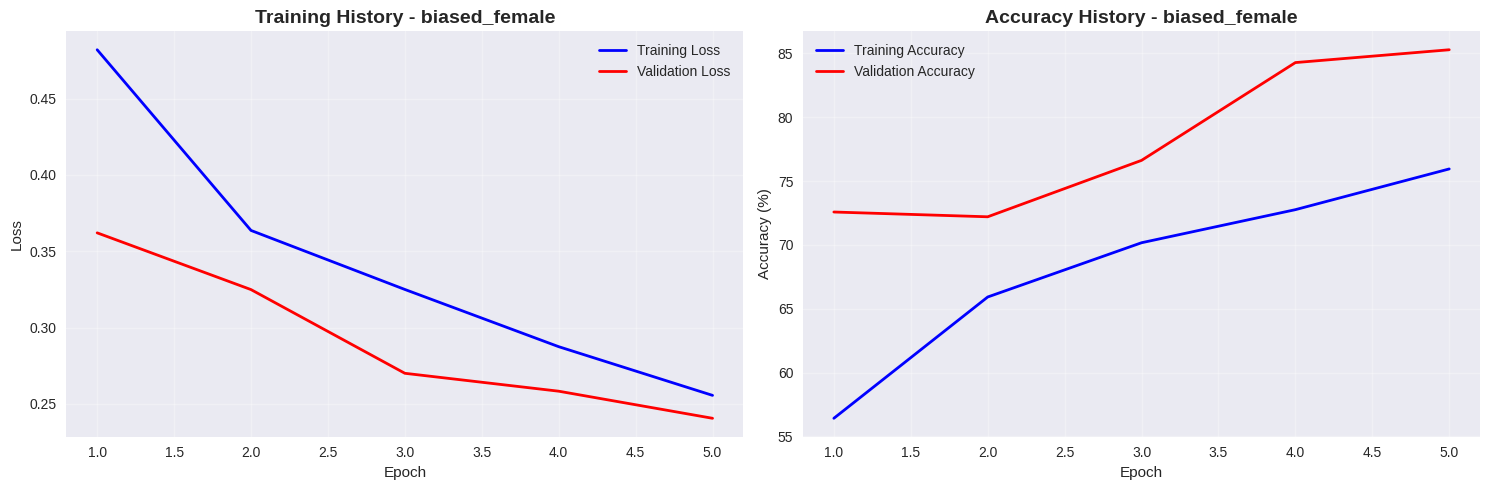

biased_female training completed!


In [39]:
# Train Female-Biased Model

config = training_configs[1]  # biased_female
print(f"\n Training: {config['description']}")

# Train model
model_path, history = train_fair_model(
    train_csv=config['train_csv'],
    val_csv=VAL_LABELS_CSV,
    train_img_dir=TRAIN_IMAGES_DIR,
    val_img_dir=VAL_IMAGES_DIR,
    architecture="resnet18",
    epochs=5,
    batch_size=16,
    learning_rate=1e-3,
    experiment_name=config['name']
)

# Plot training history
plot_training_history(history, config['name'])

# Store results
results[config['name']] = {
    'model_path': model_path,
    'training_history': history,
    'description': config['description']
}

print(f"{config['name']} training completed!")



 Training: Balanced training (50% Male, 50% Female)

 Training Fair Model: balanced
Architecture: resnet18
Epochs: 5, Batch Size: 16, LR: 0.001
 Dataset initialized: 10000 samples
 File column: file
 Label column: gender
 Dataset initialized: 10954 samples
 File column: file
 Label column: gender

 Starting Training...

Epoch 1/5


Train Loss: 0.6136, Train Acc: 64.04%
Val Loss: 0.6922, Val Acc: 60.47%
New best model saved! Val Acc: 60.47%

Epoch 2/5


Train Loss: 0.4900, Train Acc: 71.09%
Val Loss: 0.4099, Val Acc: 80.24%
New best model saved! Val Acc: 80.24%

Epoch 3/5


Train Loss: 0.4326, Train Acc: 74.89%
Val Loss: 0.4558, Val Acc: 77.68%

Epoch 4/5


Train Loss: 0.3826, Train Acc: 76.54%
Val Loss: 0.3323, Val Acc: 84.87%
New best model saved! Val Acc: 84.87%

Epoch 5/5


Train Loss: 0.3431, Train Acc: 79.32%
Val Loss: 0.2952, Val Acc: 87.16%
New best model saved! Val Acc: 87.16%

 Training completed! Best Val Acc: 87.16%


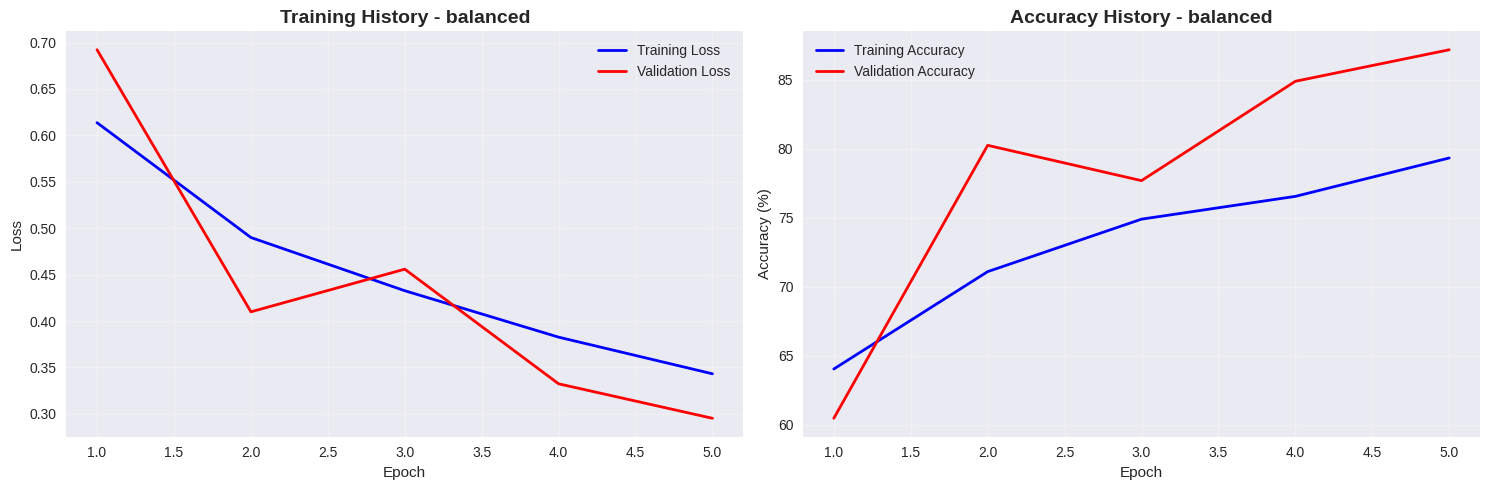

balanced training completed!
 All model training completed!


In [40]:
# Train Balanced Model

config = training_configs[2]  # balanced
print(f"\n Training: {config['description']}")

# Train model
model_path, history = train_fair_model(
    train_csv=config['train_csv'],
    val_csv=VAL_LABELS_CSV,
    train_img_dir=TRAIN_IMAGES_DIR,
    val_img_dir=VAL_IMAGES_DIR,
    architecture="resnet18",
    epochs=5,
    batch_size=16,
    learning_rate=1e-3,
    experiment_name=config['name']
)

# Plot training history
plot_training_history(history, config['name'])

# Store results
results[config['name']] = {
    'model_path': model_path,
    'training_history': history,
    'description': config['description']
}

print(f"{config['name']} training completed!")
print(" All model training completed!")

 EVALUATING + EXPLAINING: biased_male
---------------------------------------------
 Dataset initialized: 10954 samples
 File column: file
 Label column: gender
 Step 1: Model Evaluation


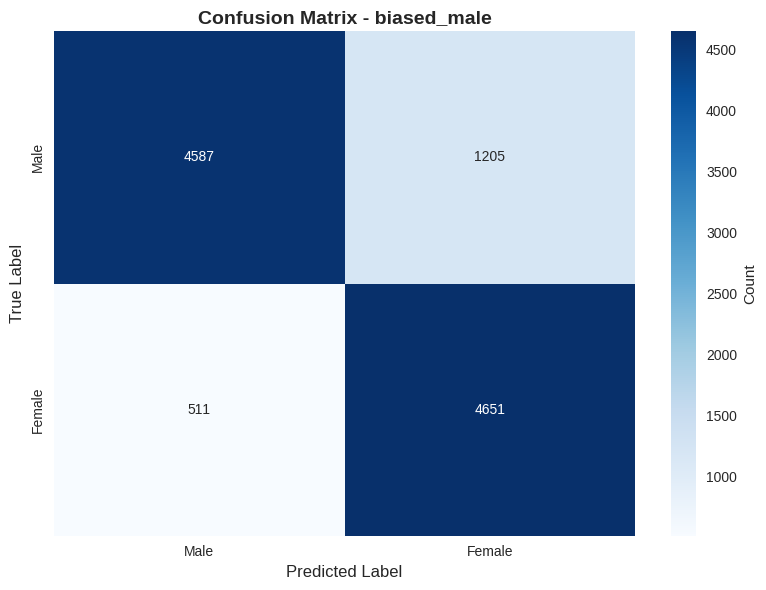

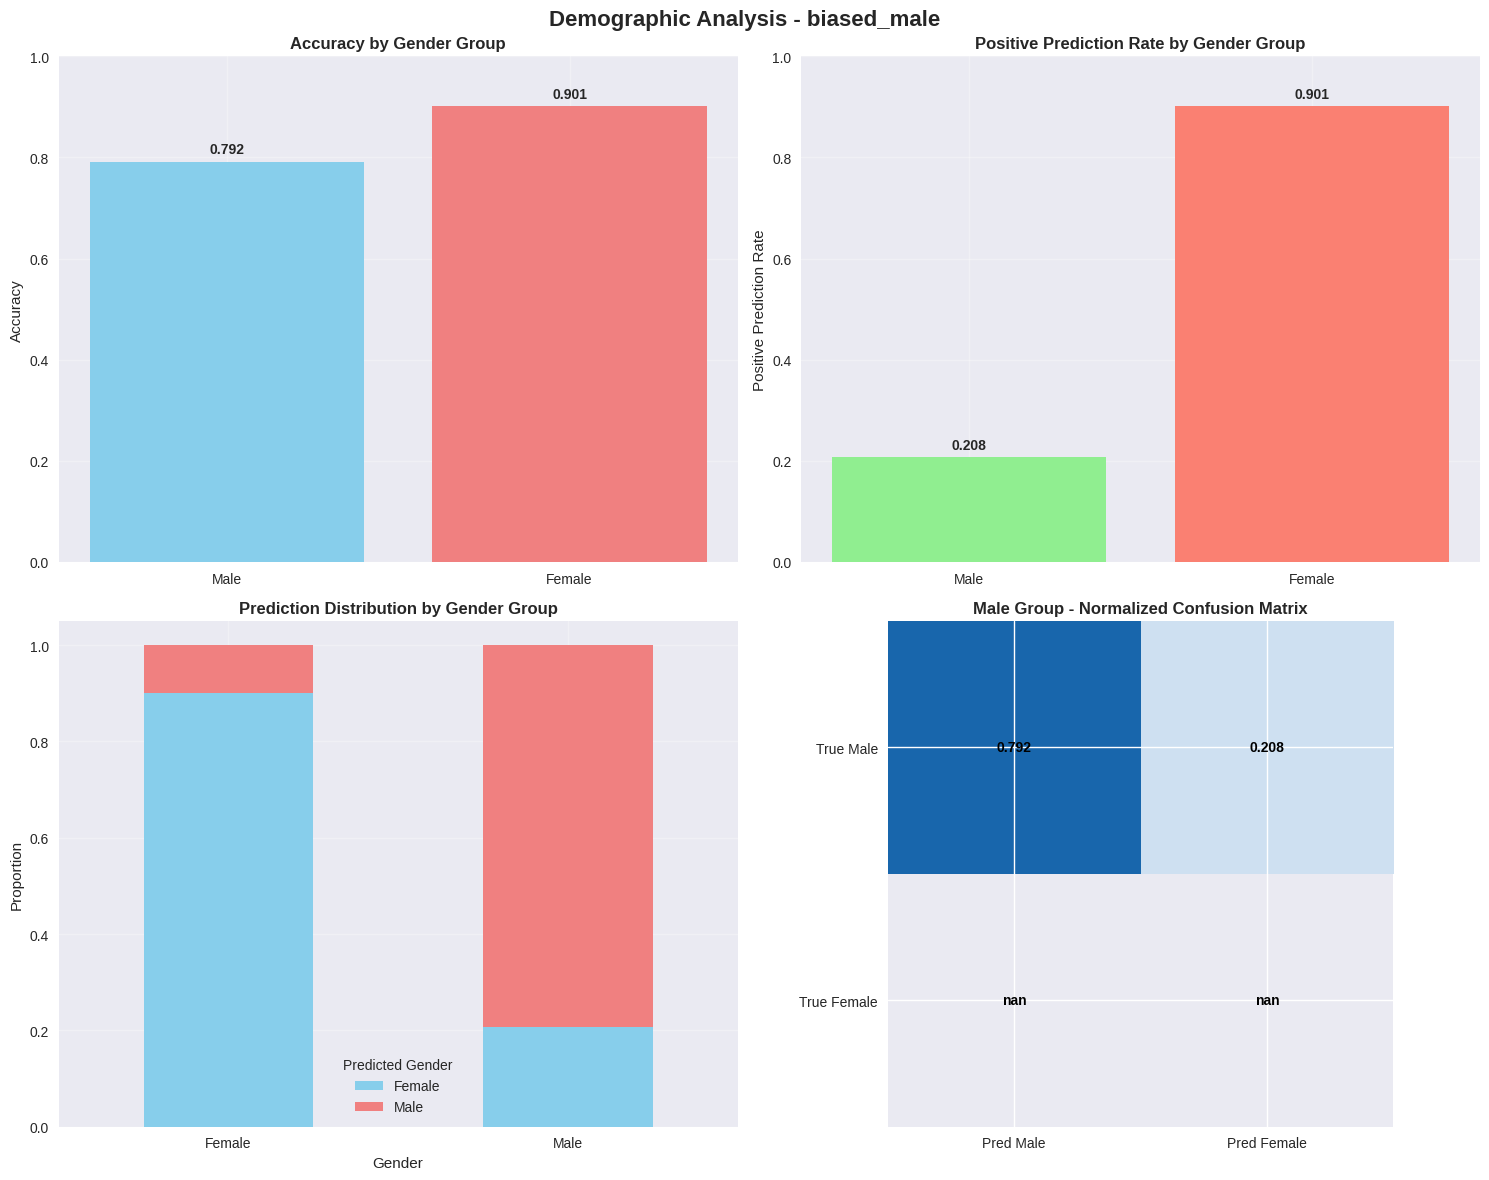

   Validation Accuracy: 84.33%
   Male Accuracy: 0.792
   Female Accuracy: 0.901
   Demographic Parity Difference: 0.693
   Equalized Odds Difference: 0.555

 Step 2: Post-hoc Explainability (GradCAM)

 Generating Model Explanations for biased_male


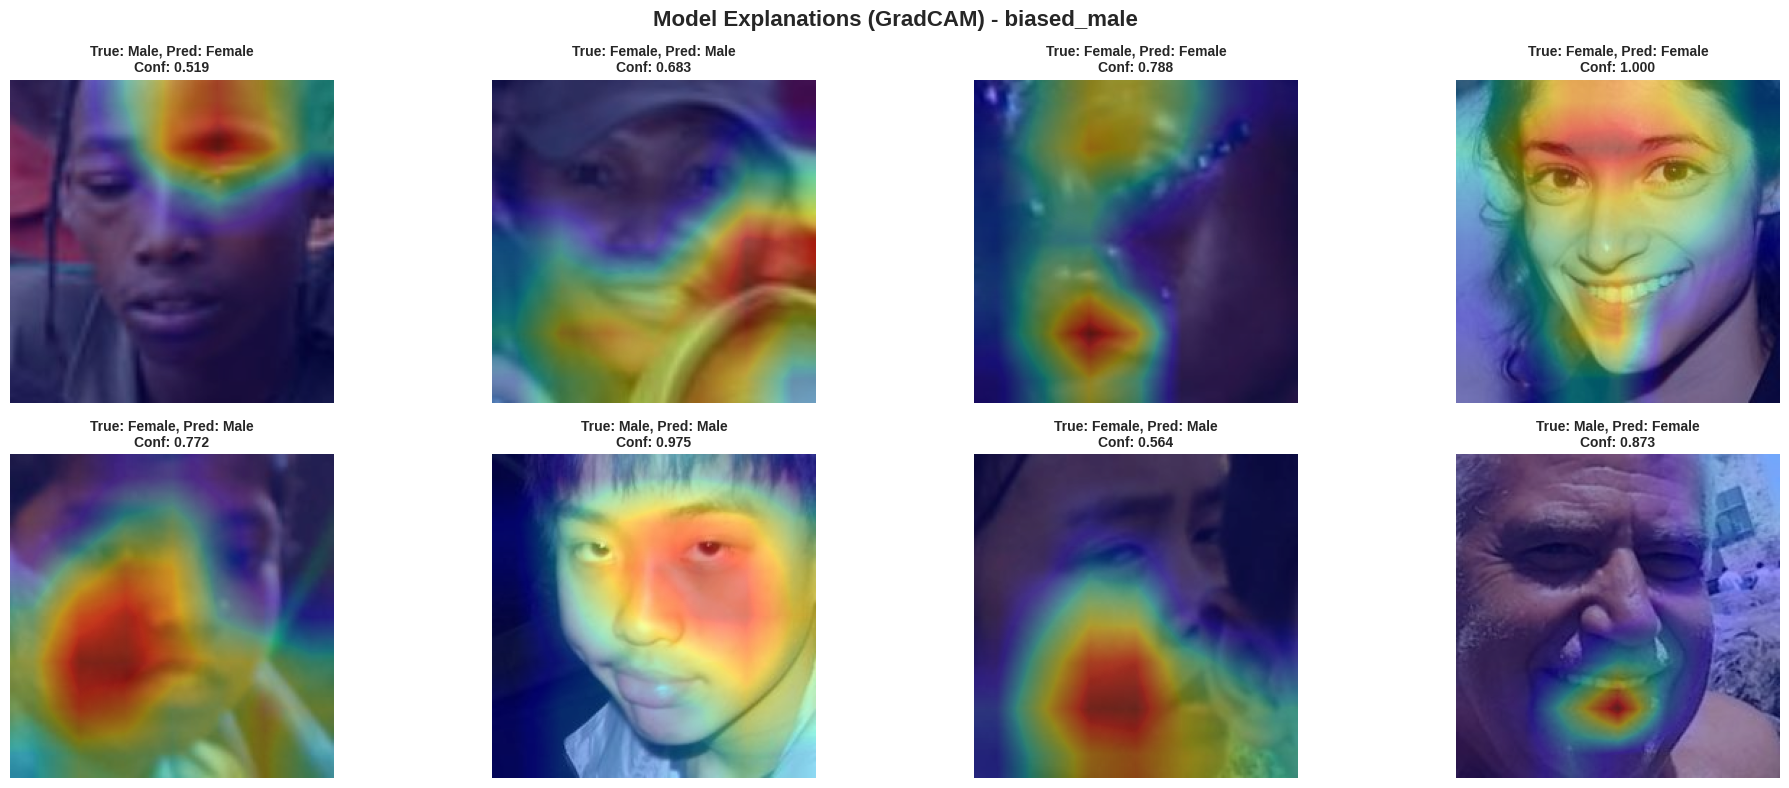

biased_male evaluation + explainability completed!


In [41]:
# Evaluate Male-Biased Model + GradCAM Explainability

print(" EVALUATING + EXPLAINING: biased_male")
print("-" * 45)

exp_name = 'biased_male'
exp_data = results[exp_name]

# Load model
checkpoint = torch.load(exp_data['model_path'], map_location=device)
model = create_model("resnet18", num_classes=2, pretrained=False).to(device)
model.load_state_dict(checkpoint['model_state_dict'])

# Create validation dataset
val_dataset = FairFaceDataset(VAL_LABELS_CSV, VAL_IMAGES_DIR, augment=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

print(" Step 1: Model Evaluation")
# Evaluate
criterion = nn.CrossEntropyLoss()
val_loss, val_acc, y_true, y_pred, y_probs = evaluate_model(model, val_loader, criterion, device)

protected_attr = y_true.copy()

fairness_metrics = compute_fairness_metrics(y_true, y_pred, y_probs[:, 1], protected_attr)

# Generate evaluation visualizations
plot_confusion_matrix(y_true, y_pred, exp_name)
plot_demographic_analysis(y_true, y_pred, protected_attr, exp_name)

# Store evaluation results
results[exp_name].update({
    'val_accuracy': val_acc,
    'val_loss': val_loss,
    'fairness_metrics': fairness_metrics,
    'y_true': y_true,
    'y_pred': y_pred,
    'y_probs': y_probs
})

# Print evaluation summary
print(f"   Validation Accuracy: {val_acc:.2f}%")
print(f"   Male Accuracy: {fairness_metrics['group_0_accuracy']:.3f}")
print(f"   Female Accuracy: {fairness_metrics['group_1_accuracy']:.3f}")
print(f"   Demographic Parity Difference: {fairness_metrics['demographic_parity_difference']:.3f}")
print(f"   Equalized Odds Difference: {fairness_metrics['equalized_odds_difference']:.3f}")

print("\n Step 2: Post-hoc Explainability (GradCAM)")
# Post-hoc explainability
visualize_model_explanations(model, val_dataset, device, num_samples=8, experiment_name=exp_name)

print(f"{exp_name} evaluation + explainability completed!")


 EVALUATING + EXPLAINING: biased_female
---------------------------------------------
 Dataset initialized: 10954 samples
 File column: file
 Label column: gender
 Step 1: Model Evaluation


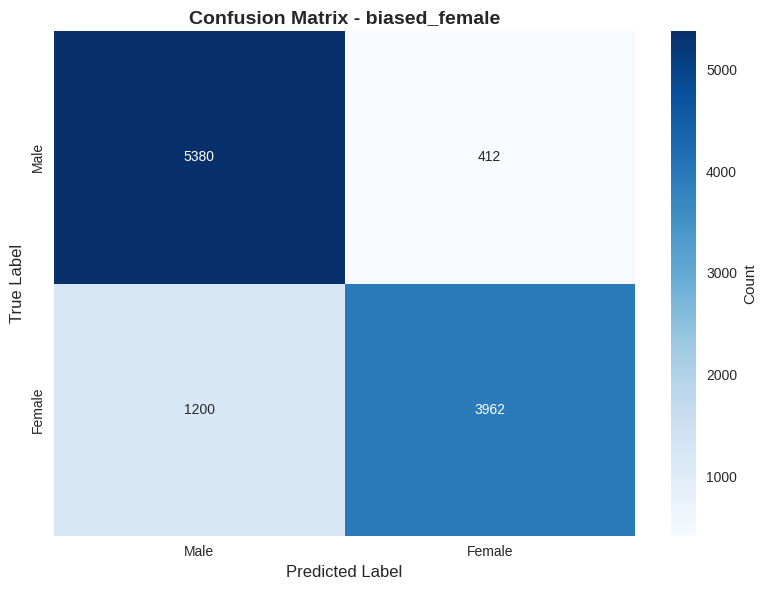

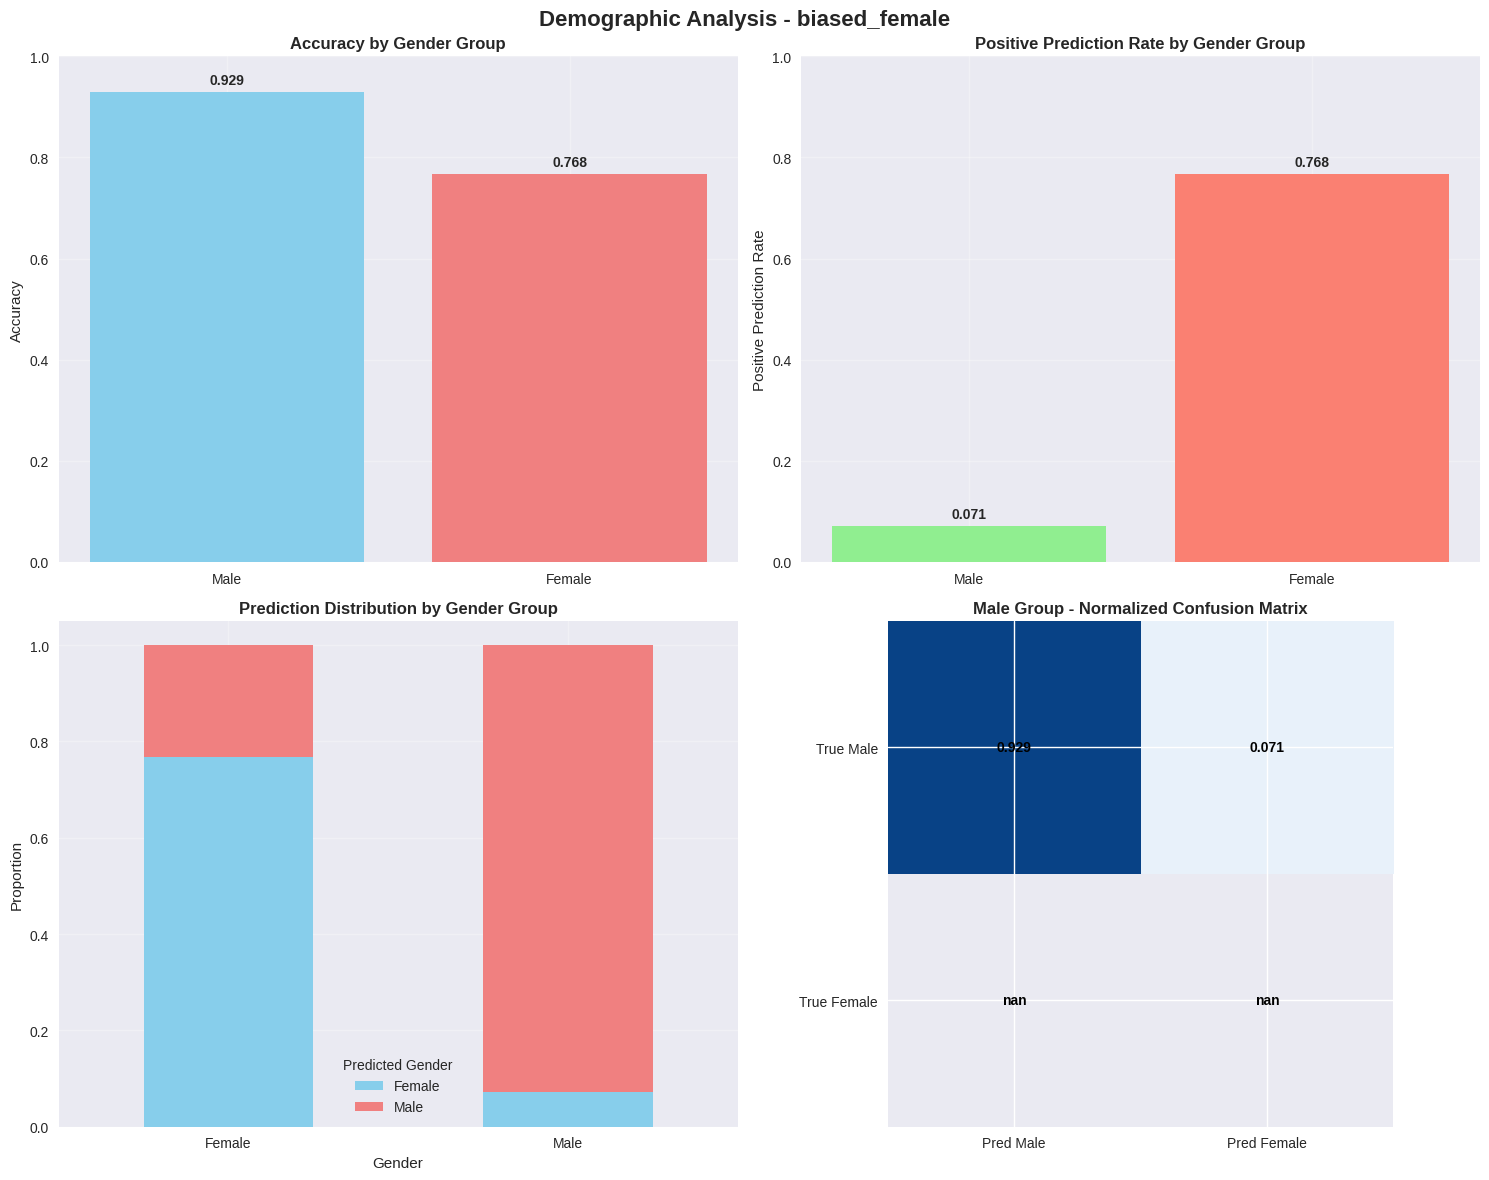

   Validation Accuracy: 85.28%
   Male Accuracy: 0.929
   Female Accuracy: 0.768
   Demographic Parity Difference: 0.696
   Equalized Odds Difference: 0.419

 Step 2: Post-hoc Explainability (GradCAM)

 Generating Model Explanations for biased_female


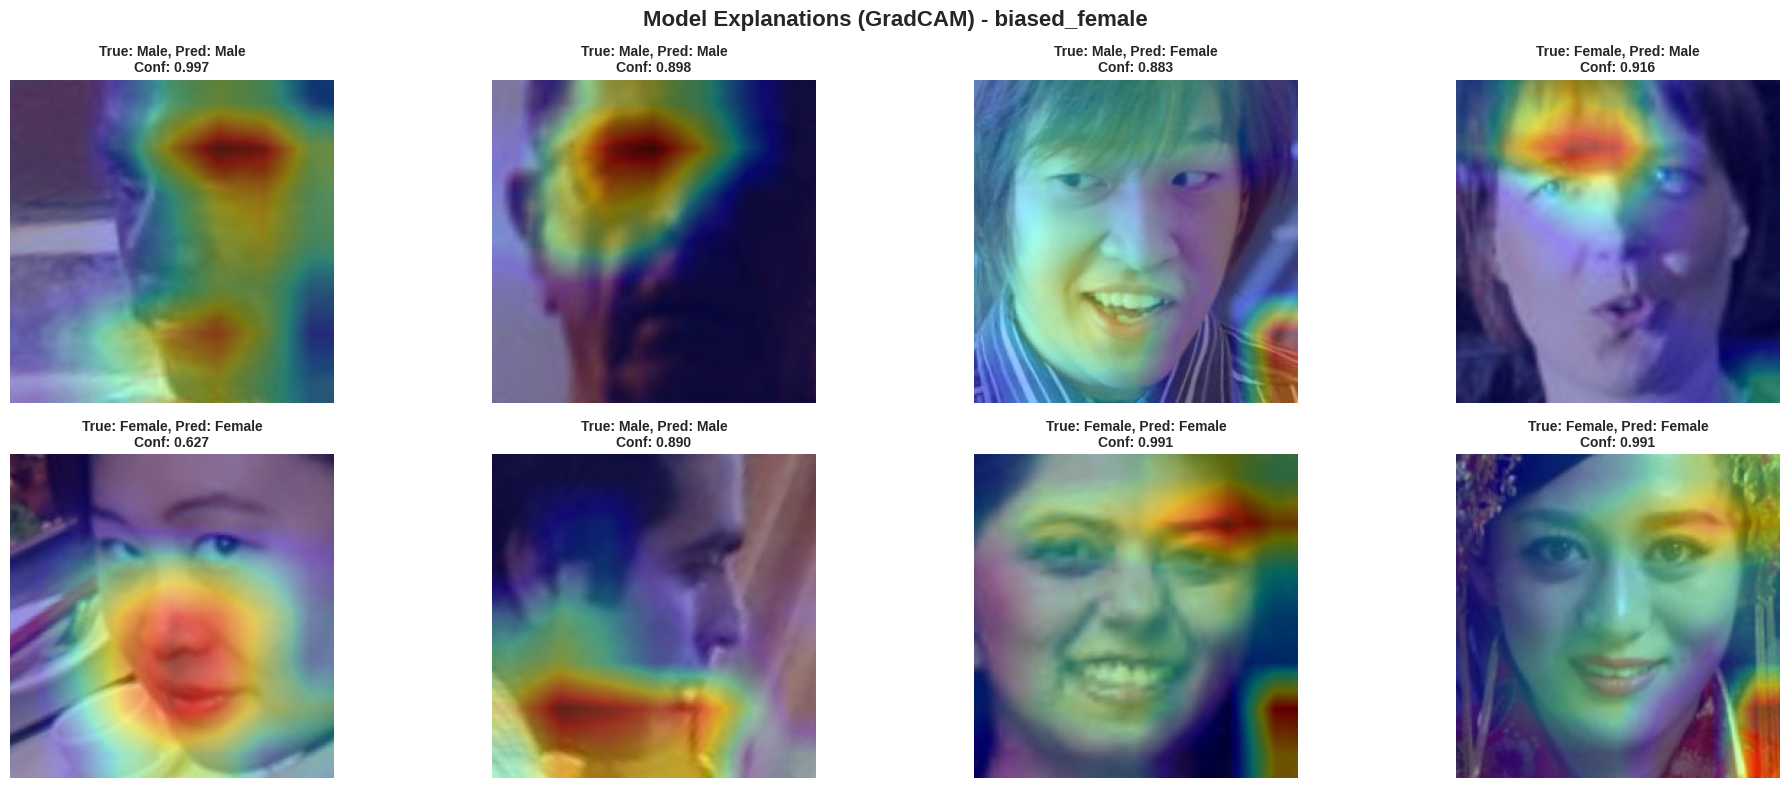

biased_female evaluation + explainability completed!


In [42]:
# Evaluate Female-Biased Model + GradCAM Explainability  

print(" EVALUATING + EXPLAINING: biased_female")
print("-" * 45)

exp_name = 'biased_female'
exp_data = results[exp_name]

# Load model
checkpoint = torch.load(exp_data['model_path'], map_location=device)
model = create_model("resnet18", num_classes=2, pretrained=False).to(device)
model.load_state_dict(checkpoint['model_state_dict'])

# Create validation dataset
val_dataset = FairFaceDataset(VAL_LABELS_CSV, VAL_IMAGES_DIR, augment=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

print(" Step 1: Model Evaluation")
# Evaluate
criterion = nn.CrossEntropyLoss()
val_loss, val_acc, y_true, y_pred, y_probs = evaluate_model(model, val_loader, criterion, device)

protected_attr = y_true.copy()

fairness_metrics = compute_fairness_metrics(y_true, y_pred, y_probs[:, 1], protected_attr)

# Generate evaluation visualizations
plot_confusion_matrix(y_true, y_pred, exp_name)
plot_demographic_analysis(y_true, y_pred, protected_attr, exp_name)

# Store evaluation results
results[exp_name].update({
    'val_accuracy': val_acc,
    'val_loss': val_loss,
    'fairness_metrics': fairness_metrics,
    'y_true': y_true,
    'y_pred': y_pred,
    'y_probs': y_probs
})

# Print evaluation summary
print(f"   Validation Accuracy: {val_acc:.2f}%")
print(f"   Male Accuracy: {fairness_metrics['group_0_accuracy']:.3f}")
print(f"   Female Accuracy: {fairness_metrics['group_1_accuracy']:.3f}")
print(f"   Demographic Parity Difference: {fairness_metrics['demographic_parity_difference']:.3f}")
print(f"   Equalized Odds Difference: {fairness_metrics['equalized_odds_difference']:.3f}")

print("\n Step 2: Post-hoc Explainability (GradCAM)")
# Post-hoc explainability
visualize_model_explanations(model, val_dataset, device, num_samples=8, experiment_name=exp_name)

print(f"{exp_name} evaluation + explainability completed!")

 EVALUATING + EXPLAINING: balanced
---------------------------------------------
 Dataset initialized: 10954 samples
 File column: file
 Label column: gender
 Step 1: Model Evaluation


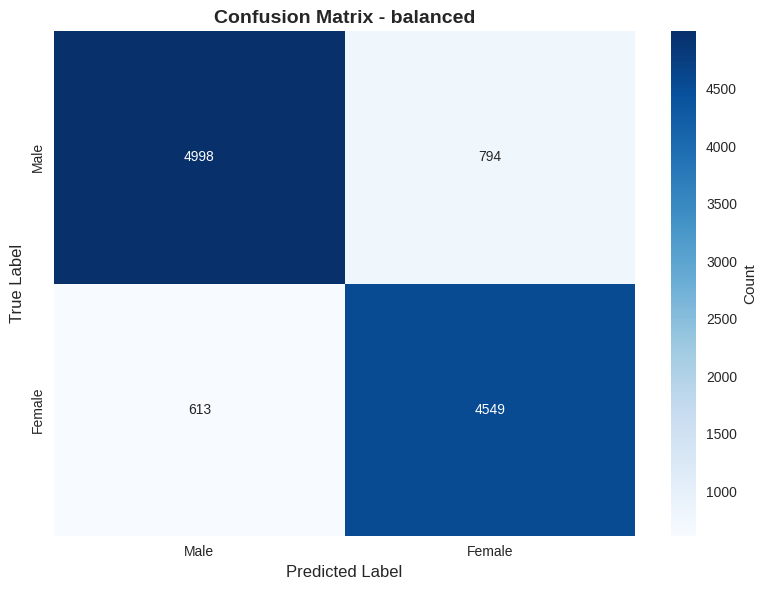

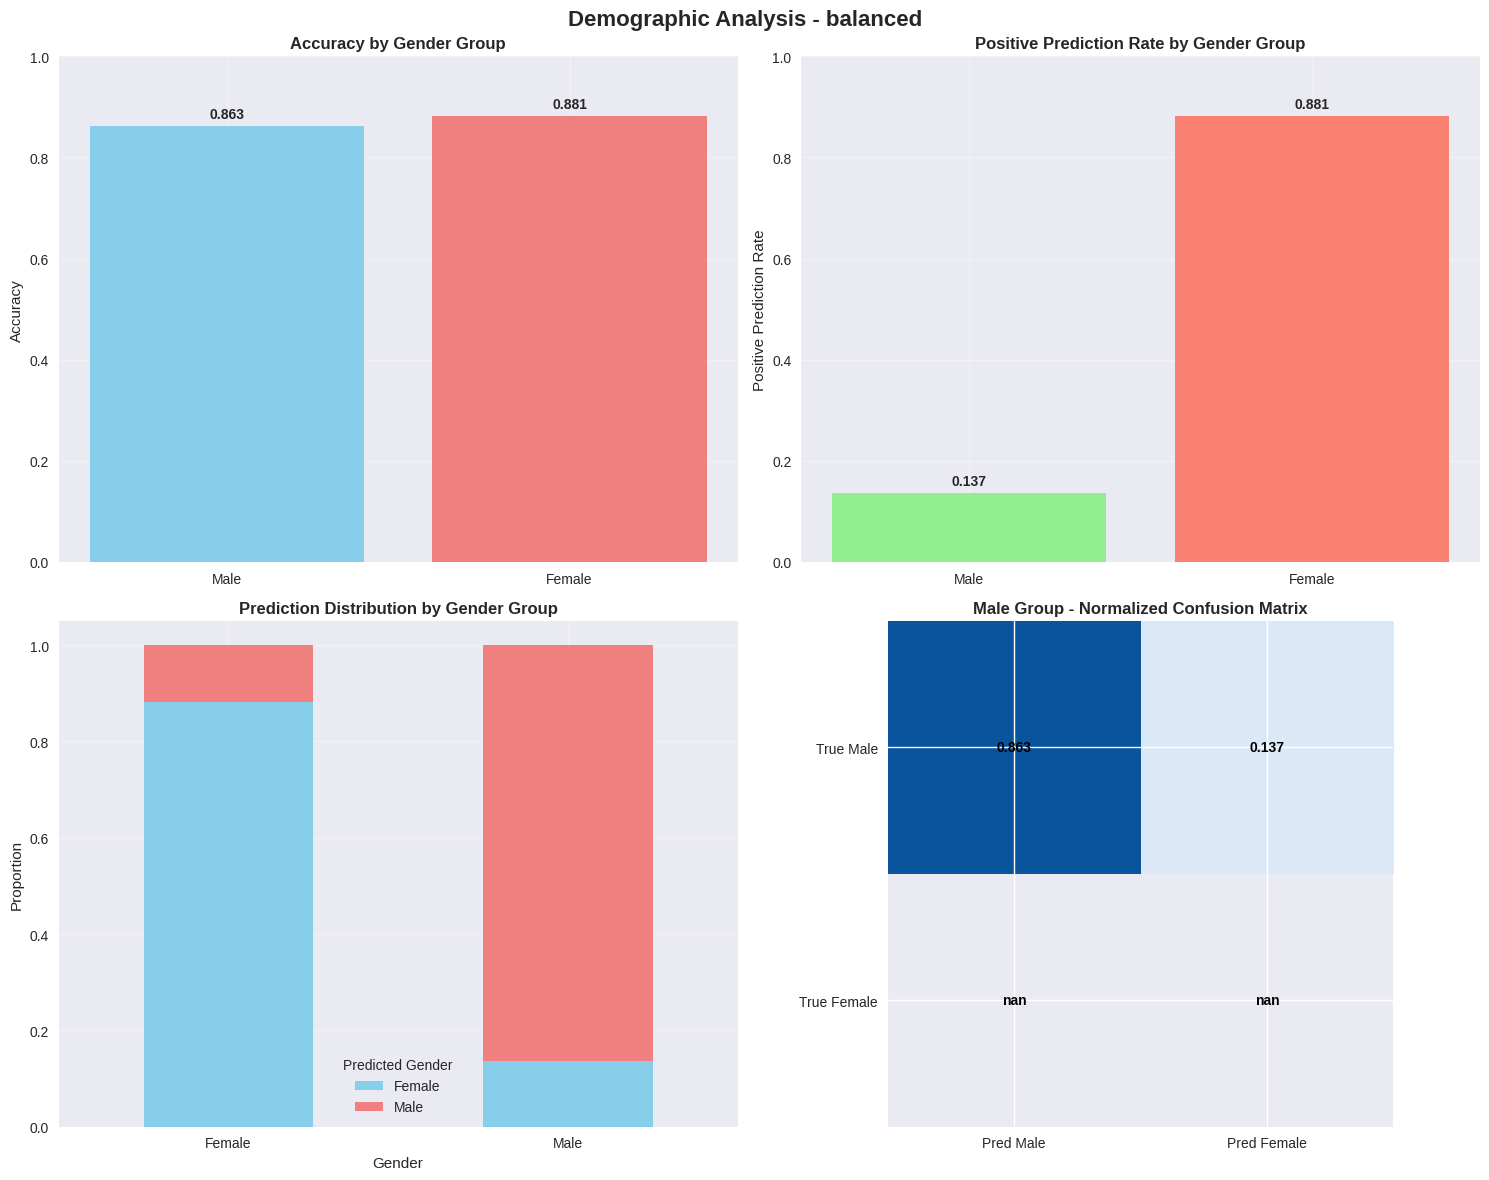

   Validation Accuracy: 87.16%
   Male Accuracy: 0.863
   Female Accuracy: 0.881
   Demographic Parity Difference: 0.744
   Equalized Odds Difference: 0.509

 Step 2: Post-hoc Explainability (GradCAM)

 Generating Model Explanations for balanced


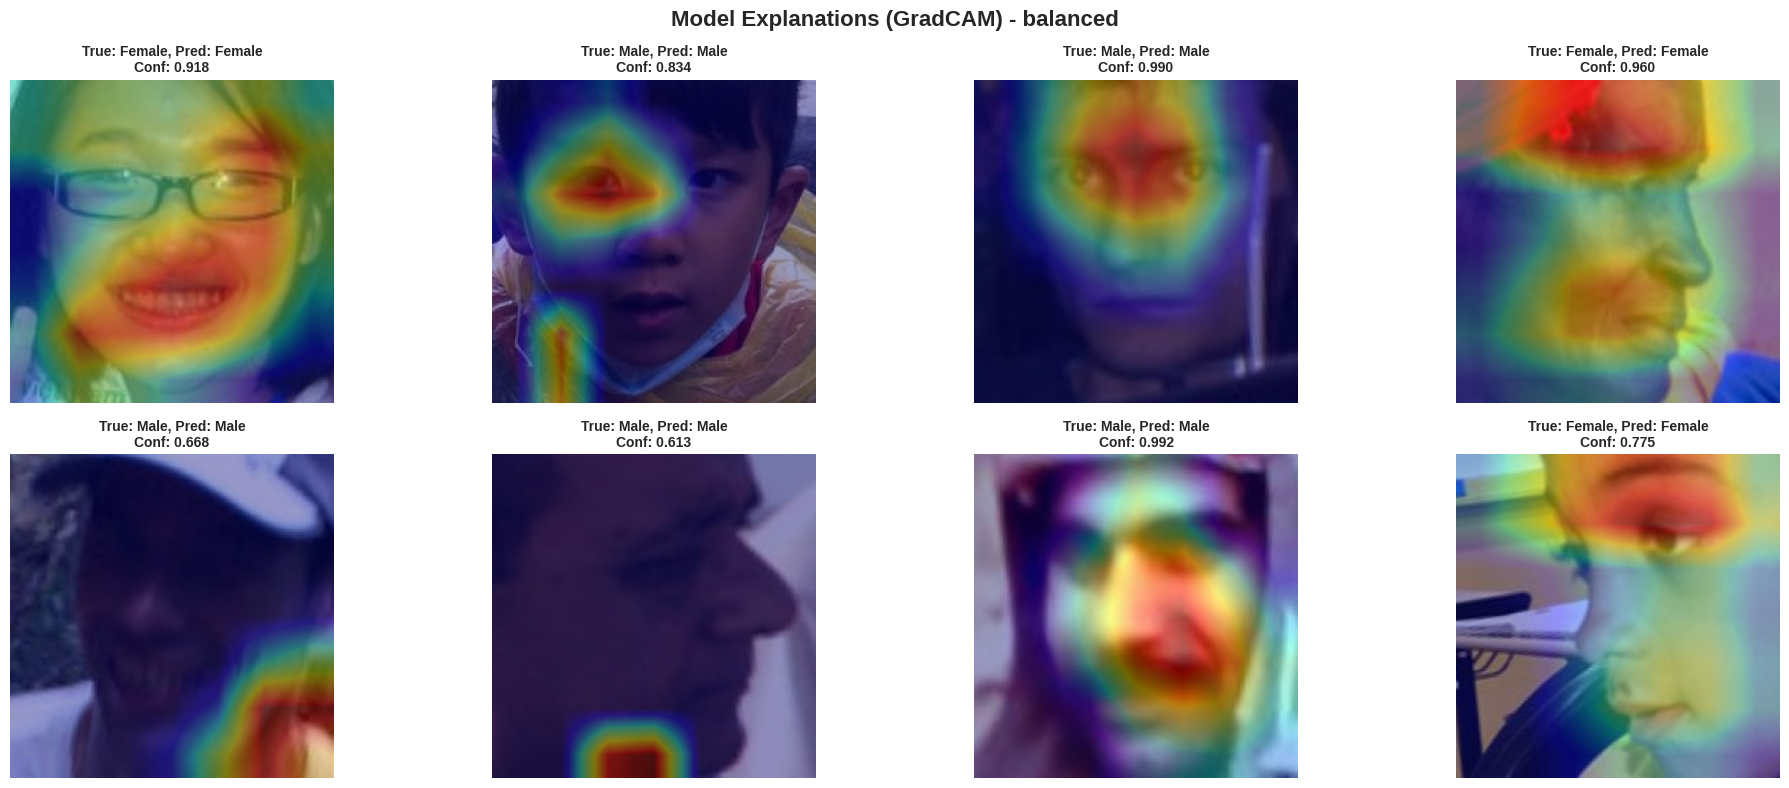

balanced evaluation + explainability completed!
All model evaluations + explanations completed!


In [43]:
# Evaluate Balanced Model + GradCAM Explainability

print(" EVALUATING + EXPLAINING: balanced")
print("-" * 45)

exp_name = 'balanced'
exp_data = results[exp_name]

# Load model
checkpoint = torch.load(exp_data['model_path'], map_location=device)
model = create_model("resnet18", num_classes=2, pretrained=False).to(device)
model.load_state_dict(checkpoint['model_state_dict'])

# Create validation dataset
val_dataset = FairFaceDataset(VAL_LABELS_CSV, VAL_IMAGES_DIR, augment=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

print(" Step 1: Model Evaluation")
# Evaluate
criterion = nn.CrossEntropyLoss()
val_loss, val_acc, y_true, y_pred, y_probs = evaluate_model(model, val_loader, criterion, device)

protected_attr = y_true.copy()

fairness_metrics = compute_fairness_metrics(y_true, y_pred, y_probs[:, 1], protected_attr)

# Generate evaluation visualizations
plot_confusion_matrix(y_true, y_pred, exp_name)
plot_demographic_analysis(y_true, y_pred, protected_attr, exp_name)

# Store evaluation results
results[exp_name].update({
    'val_accuracy': val_acc,
    'val_loss': val_loss,
    'fairness_metrics': fairness_metrics,
    'y_true': y_true,
    'y_pred': y_pred,
    'y_probs': y_probs
})

# Print evaluation summary
print(f"   Validation Accuracy: {val_acc:.2f}%")
print(f"   Male Accuracy: {fairness_metrics['group_0_accuracy']:.3f}")
print(f"   Female Accuracy: {fairness_metrics['group_1_accuracy']:.3f}")
print(f"   Demographic Parity Difference: {fairness_metrics['demographic_parity_difference']:.3f}")
print(f"   Equalized Odds Difference: {fairness_metrics['equalized_odds_difference']:.3f}")

print("\n Step 2: Post-hoc Explainability (GradCAM)")
# Post-hoc explainability
visualize_model_explanations(model, val_dataset, device, num_samples=8, experiment_name=exp_name)

print(f"{exp_name} evaluation + explainability completed!")
print("All model evaluations + explanations completed!")

 COMPREHENSIVE FAIRNESS DASHBOARD
--------------------------------------------------


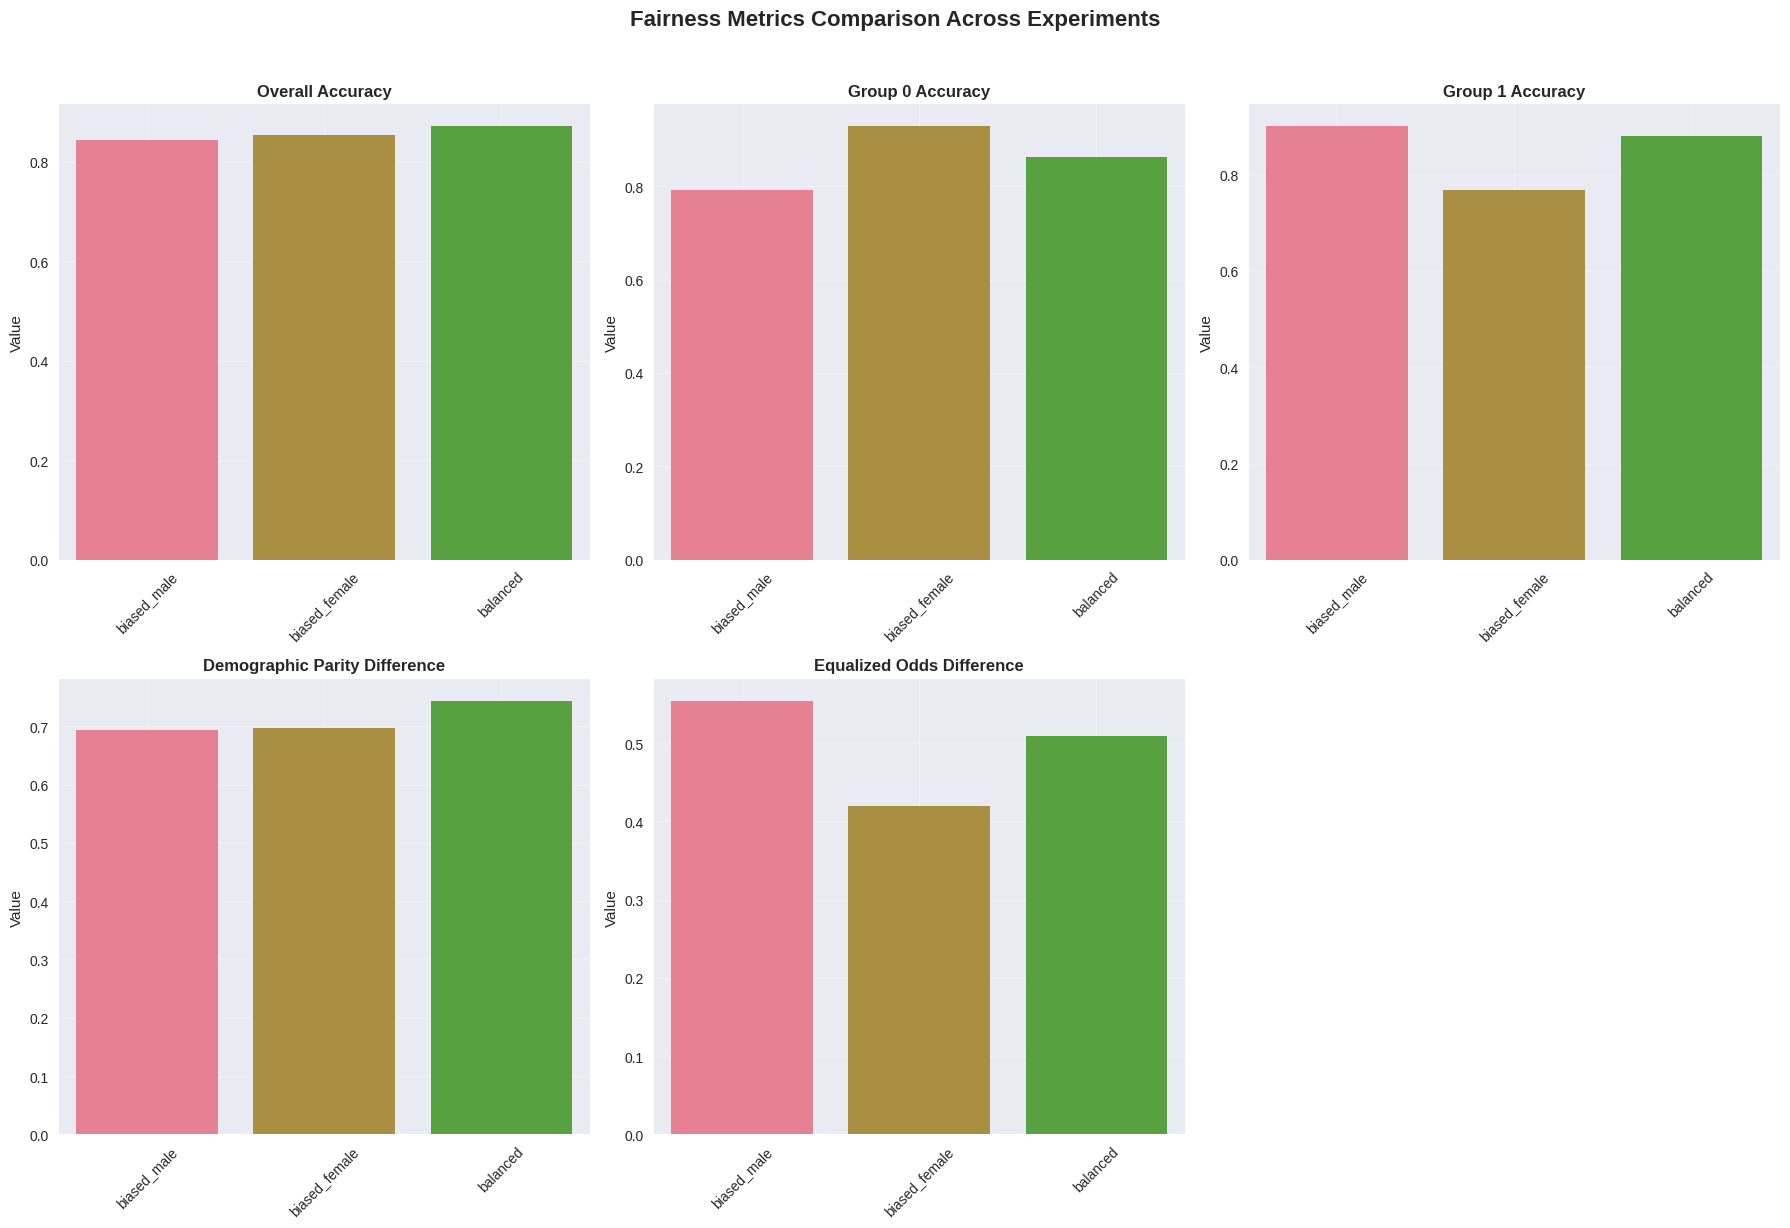

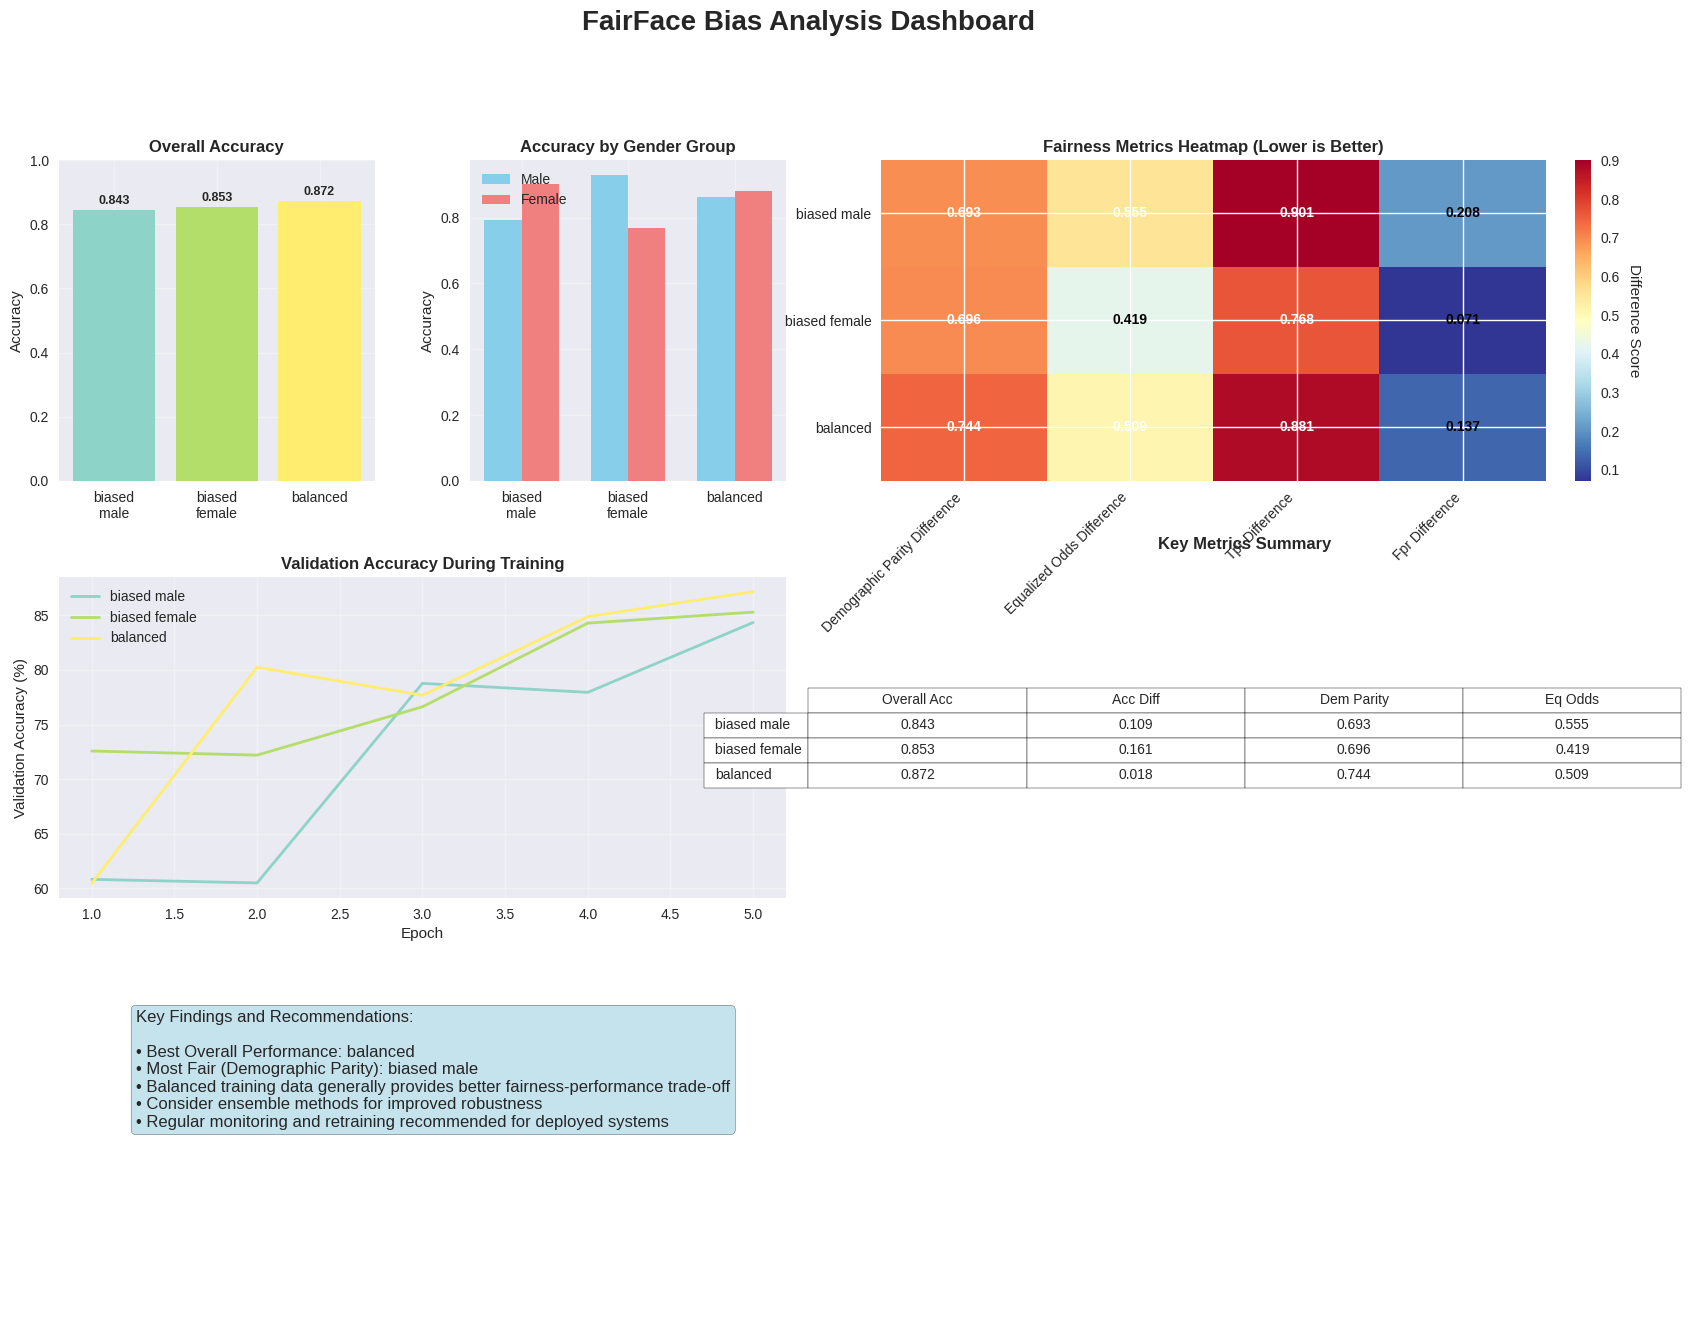

In [44]:
# Comprehensive Dashboard and Comparison

print(" COMPREHENSIVE FAIRNESS DASHBOARD")
print("-" * 50)

# Fairness comparison
plot_fairness_metrics_comparison(results)

# Comprehensive dashboard
create_fairness_dashboard(results)

